In [1]:
import os
import itertools
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
#from sklearn.metrics import make_scorer
from time import time

#import scipy
import librosa
#import sed_eval

import matplotlib.pyplot as plt
import matplotlib.cm
from sklearn.model_selection import GroupKFold
from sklearn.externals.joblib import parallel_backend
#import csv
#import dcase_util

#import pandas as pd

In [2]:

def LoadSet(SetPath):
    Data_Set = {}
    dataset = np.load(SetPath,allow_pickle=True)
    Data = np.hstack(dataset[:,0].tolist()).transpose()
    Label = np.hstack(dataset[:,1].tolist())
    print(Data.shape)
    print(Label.shape)
    Data_Set['Data'] = Data
    Data_Set['Label'] = Label
    return Data_Set
def sklearn_print_result(clf,test_data,test_label):
    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = test_label, clf.predict(test_data)
    print(metrics.classification_report(y_true, y_pred))
    print()

# MFCC/Original Dataset/RandomCV

In [44]:



#Load the dataset
train_path= os.getcwd()+'/JPNotebookExported/Train_PCEN_Dataset.npy'
#example_validation_path = os.getcwd()+'/JPNotebookExported/Validation_MFCC_Dataset.npy'
#test_path = os.getcwd()+'/JPNotebookExported/Test_MFCC_Dataset.npy'

#Load Transition Matrix
#example_train_transition_matrix = np.load(os.getcwd()+'/JPNotebookExported/Train_PCEN_TransitionMatrix.npy',allow_pickle=True)
#example_test_transition_matrix = np.load(os.getcwd()+'/JPNotebookExported/Test_PCEN_TransitionMatrix.npy',allow_pickle=True)
#Load all the data and label
train_set= LoadSet(train_path)
train_data,train_label = train_set['Data'], train_set['Label']
#test_data,test_label = test_set['Data'], test_set['Label']




(2586015, 20)
(2586015,)


In [46]:
groups = np.load(os.getcwd()+'/JPNotebookExported/Train_PCEN_lostanlen_GroupK.npy')
gkf = GroupKFold(n_splits = 3)
Params = {
    'sampling_rate':22050,
    'win_size':1024,
    'hop_size':512,
    'min_freq':80,
    'max_freq':8000,
    'num_mel_filters':128,
    'n_dct':20
}

param_grid = {"n_estimators": np.arange(10, 400, 40),
              "max_depth": np.arange(1, 50, 5),
              "min_samples_split": np.arange(2,12,4),
              "min_samples_leaf": np.arange(1,24,6)
             }

scoring = ['roc_auc','balanced_accuracy']
pcen_clf = RandomForestClassifier(n_estimators=400,
                             #max_depth = 5,
                             #min_samples_split = 15, 
                             #min_samples_leaf = 370,
                             oob_score=True,
                             random_state=10,
                             verbose=1, n_jobs = -1,class_weight='balanced')
grid_search_pcen = GridSearchCV(pcen_clf,param_grid=param_grid,cv = gkf,refit = 'roc_auc',scoring = scoring)

start_time = time()
with parallel_backend('threading'):
    grid_search_pcen.fit(train_data,train_label,groups = groups)
print("Grid Searching took {} mins." .format((time() - start_time)/60.0))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 18.4min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 18.5min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 18.6min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 81.0min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 81.4min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 82.9min
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed: 162.5min finished
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed: 162.8min finished
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed: 163.7min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.3s
[Parallel(n_jobs=4)]: Using 

Grid Searching took 238.20238478581112 mins.


In [28]:
grid_search_pcen_los.best_score_

0.8734525792123479

In [47]:
grid_search_pcen.best_score_

0.8705839603435369

In [11]:
test_path= os.getcwd()+'/JPNotebookExported/Test_PCEN_lostanlen_Dataset.npy'
test_set= LoadSet(test_path)
test_data,test_label = test_set['Data'], test_set['Label']

(861138, 20)
(861138,)


In [12]:
def sklearn_print_result(clf,test_data,test_label):
    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_roc_auc']
    stds = clf.cv_results_['std_test_roc_auc']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = test_label, clf.predict(test_data)
    print(metrics.classification_report(y_true, y_pred))
    print()
sklearn_print_result(grid_search_pcen_los,test_data,test_label)

Best parameters set found on development set:

{'max_depth': 60, 'min_samples_leaf': 7, 'min_samples_split': 6}

Grid scores on development set:

0.848 (+/-0.001) for {'max_depth': 10, 'min_samples_leaf': 7, 'min_samples_split': 6}
0.848 (+/-0.001) for {'max_depth': 10, 'min_samples_leaf': 7, 'min_samples_split': 12}
0.848 (+/-0.001) for {'max_depth': 10, 'min_samples_leaf': 7, 'min_samples_split': 20}
0.849 (+/-0.001) for {'max_depth': 10, 'min_samples_leaf': 15, 'min_samples_split': 6}
0.849 (+/-0.001) for {'max_depth': 10, 'min_samples_leaf': 15, 'min_samples_split': 12}
0.849 (+/-0.001) for {'max_depth': 10, 'min_samples_leaf': 15, 'min_samples_split': 20}
0.848 (+/-0.001) for {'max_depth': 10, 'min_samples_leaf': 23, 'min_samples_split': 6}
0.848 (+/-0.001) for {'max_depth': 10, 'min_samples_leaf': 23, 'min_samples_split': 12}
0.848 (+/-0.001) for {'max_depth': 10, 'min_samples_leaf': 23, 'min_samples_split': 20}
0.872 (+/-0.002) for {'max_depth': 35, 'min_samples_leaf': 7, 'min_s

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    7.8s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   30.1s
[Parallel(n_jobs=4)]: Done 400 out of 400 | elapsed:   53.0s finished


              precision    recall  f1-score   support

           0       0.95      0.96      0.95    790138
           1       0.49      0.38      0.42     71000

   micro avg       0.92      0.92      0.92    861138
   macro avg       0.72      0.67      0.69    861138
weighted avg       0.91      0.92      0.91    861138




In [8]:
def sklearn_print_result(clf,test_data,test_label):
    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_roc_auc']
    stds = clf.cv_results_['std_test_roc_auc']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = test_label, clf.predict(test_data)
    print(metrics.classification_report(y_true, y_pred))
    print()
sklearn_print_result(grid_search_mfcc,test_data,test_label)

Best parameters set found on development set:

{'max_depth': 60, 'min_samples_leaf': 5, 'min_samples_split': 10}

Grid scores on development set:

0.862 (+/-0.002) for {'max_depth': 10, 'min_samples_leaf': 5, 'min_samples_split': 10}
0.862 (+/-0.002) for {'max_depth': 10, 'min_samples_leaf': 5, 'min_samples_split': 30}
0.862 (+/-0.002) for {'max_depth': 10, 'min_samples_leaf': 5, 'min_samples_split': 50}
0.862 (+/-0.002) for {'max_depth': 10, 'min_samples_leaf': 20, 'min_samples_split': 10}
0.862 (+/-0.002) for {'max_depth': 10, 'min_samples_leaf': 20, 'min_samples_split': 30}
0.862 (+/-0.002) for {'max_depth': 10, 'min_samples_leaf': 20, 'min_samples_split': 50}
0.861 (+/-0.002) for {'max_depth': 10, 'min_samples_leaf': 45, 'min_samples_split': 10}
0.861 (+/-0.002) for {'max_depth': 10, 'min_samples_leaf': 45, 'min_samples_split': 30}
0.861 (+/-0.002) for {'max_depth': 10, 'min_samples_leaf': 45, 'min_samples_split': 50}
0.882 (+/-0.002) for {'max_depth': 35, 'min_samples_leaf': 5, 'm

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    4.4s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:   17.7s
[Parallel(n_jobs=8)]: Done 400 out of 400 | elapsed:   36.1s finished


              precision    recall  f1-score   support

           0       0.94      0.97      0.96    792263
           1       0.45      0.24      0.31     68875

   micro avg       0.92      0.92      0.92    861138
   macro avg       0.69      0.61      0.63    861138
weighted avg       0.90      0.92      0.90    861138




In [119]:

temp_new_clf = RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', n_estimators=1000, n_jobs=-1, oob_score=True, random_state=10,
            verbose=1, warm_start=False)

train_path= os.getcwd()+'/JPNotebookExported/Train_PCEN_lostanlen_Dataset.npy'
train_set= LoadSet(train_path)
train_data,train_label = train_set['Data'], train_set['Label']
temp_new_clf.fit(train_data,train_label)

(2586015, 20)
(2586015,)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  9.7min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 43.3min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 266.8min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 348.0min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 391.7min finished


RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=1000, n_jobs=-1, oob_score=True, random_state=10,
            verbose=1, warm_start=False)

(861138, 20)
(861138,)


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.4s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   22.5s
[Parallel(n_jobs=4)]: Done 400 out of 400 | elapsed:   47.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   21.2s
[Parallel(n_jobs=4)]: Done 400 out of 400 | elapsed:   45.1s finished


0.8622666014858021
0.6701408751953082
              precision    recall  f1-score   support

           0       0.95      0.96      0.95    790138
           1       0.49      0.38      0.42     71000

   micro avg       0.92      0.92      0.92    861138
   macro avg       0.72      0.67      0.69    861138
weighted avg       0.91      0.92      0.91    861138



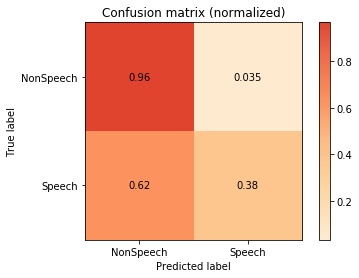

In [125]:

test_path= os.getcwd()+'/JPNotebookExported/Test_PCEN_lostanlen_Dataset.npy'
test_set= LoadSet(test_path)
test_data,test_label = test_set['Data'], test_set['Label']
y_true, y_pred, y_pred_prob = test_label, grid_search_pcen_los.predict(test_data),grid_search_pcen_los.predict_proba(test_data)[:,1]
print(metrics.roc_auc_score(y_true, y_pred_prob))
print(metrics.balanced_accuracy_score(y_true, y_pred))
#print(metrics.recall_score(y_true, y_pred))
#print(metrics.f1_score(y_true, y_pred))
print(metrics.classification_report(y_true,y_pred))

target_names = ['NonSpeech', 'Speech']
sklearn_evaluation.plot.confusion_matrix(y_true, y_pred, target_names=target_names, normalize=True, cmap=None, ax=None)
plt.show()

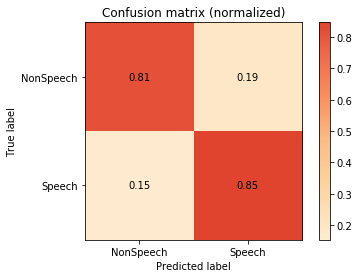

0.8300189427063535


In [129]:

viterbi_result = librosa.sequence.viterbi_binary(y_pred_prob, transition_matrix, p_state=0.26, p_init=None).ravel()
sklearn_evaluation.plot.confusion_matrix(y_true, viterbi_result, target_names=target_names, normalize=True)
plt.show()
print(metrics.balanced_accuracy_score(y_true, viterbi_result))

/Users/anderson675/miniconda3/lib/python3.7/site-packages/sklearn/base.py:253: UserWarning: Trying to unpickle estimator GridSearchCV from version 0.20.1 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


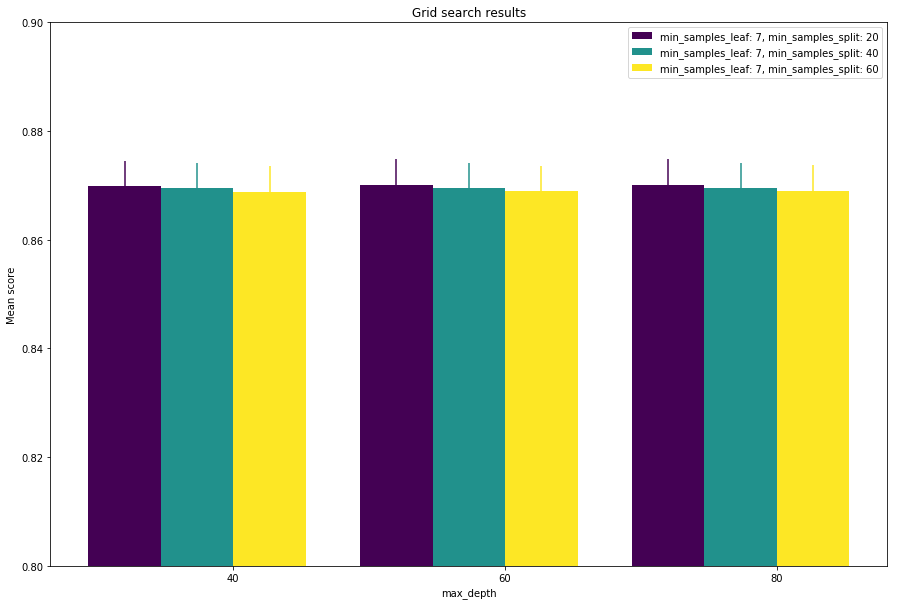

In [42]:
import sklearn_evaluation

grid_search_pcen = joblib.load('grid_search_cv_pcen_coarse4.joblib') 
to_vary = 'max_depth'

plt.figure(figsize=(15,10))

sklearn_evaluation.plot.grid_search(grid_search_pcen.cv_results_, to_vary, kind='bar')
plt.ylim([0.8, 0.9])
#plt.savefig('PCEN_Coarse2.png',dpi = 1000)
plt.show()